# Voice Gender Classification

## Gender Recognition by Voice and Speech Analysis

This notebook tries to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by analyzing frequency range of 0hz-280hz (human vocal range).

### The Dataset

The following acoustic properties of each voice are measured and included within the CSV:

- meanfreq: mean frequency (in kHz)
- sd: standard deviation of frequency
- median: median frequency (in kHz)
- Q25: first quantile (in kHz)
- Q75: third quantile (in kHz)
- IQR: interquantile range (in kHz)
- skew: skewness (see note in specprop description)
- kurt: kurtosis (see note in specprop description)
- sp.ent: spectral entropy
- sfm: spectral flatness
- mode: mode frequency
- centroid: frequency centroid (see specprop)
- peakf: peak frequency (frequency with highest energy)
- meanfun: average of fundamental frequency measured across acoustic signal
- minfun: minimum fundamental frequency measured across acoustic signal
- maxfun: maximum fundamental frequency measured across acoustic signal
- meandom: average of dominant frequency measured across acoustic signal
- mindom: minimum of dominant frequency measured across acoustic signal
- maxdom: maximum of dominant frequency measured across acoustic signal
- dfrange: range of dominant frequency measured across acoustic signal
- modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of - - - - fundamental frequencies divided by the frequency range
- label: male or female

## Gender classification - typical rules of thumb

- Pitch, combined with intonation (the rise and fall of the voice in speaking), are important factors in classifying male versus female.
- Male classified voices tend to be low and within a narrow range of pitch (ie., relatively monotone).
- Female classified voices tend to be higher in pitch and fluctuate frequency to a much greater degree.
- Female classified voices often rise in frequency at the end of a sentence, as if asking a question.


In [46]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import pydotplus
from IPython.display import Image  

pd.options.mode.chained_assignment = None  # default='warn'

matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams.update({'font.size': 15})

def plot_feature_importances_mydata(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), list(mydata)[:-1])
    plt.xlabel("Variable importance")
    plt.ylabel("Independent Variable")

In [47]:
#Read the voice dataset
mydata = pd.read_csv("data/voice.csv")

mydata

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


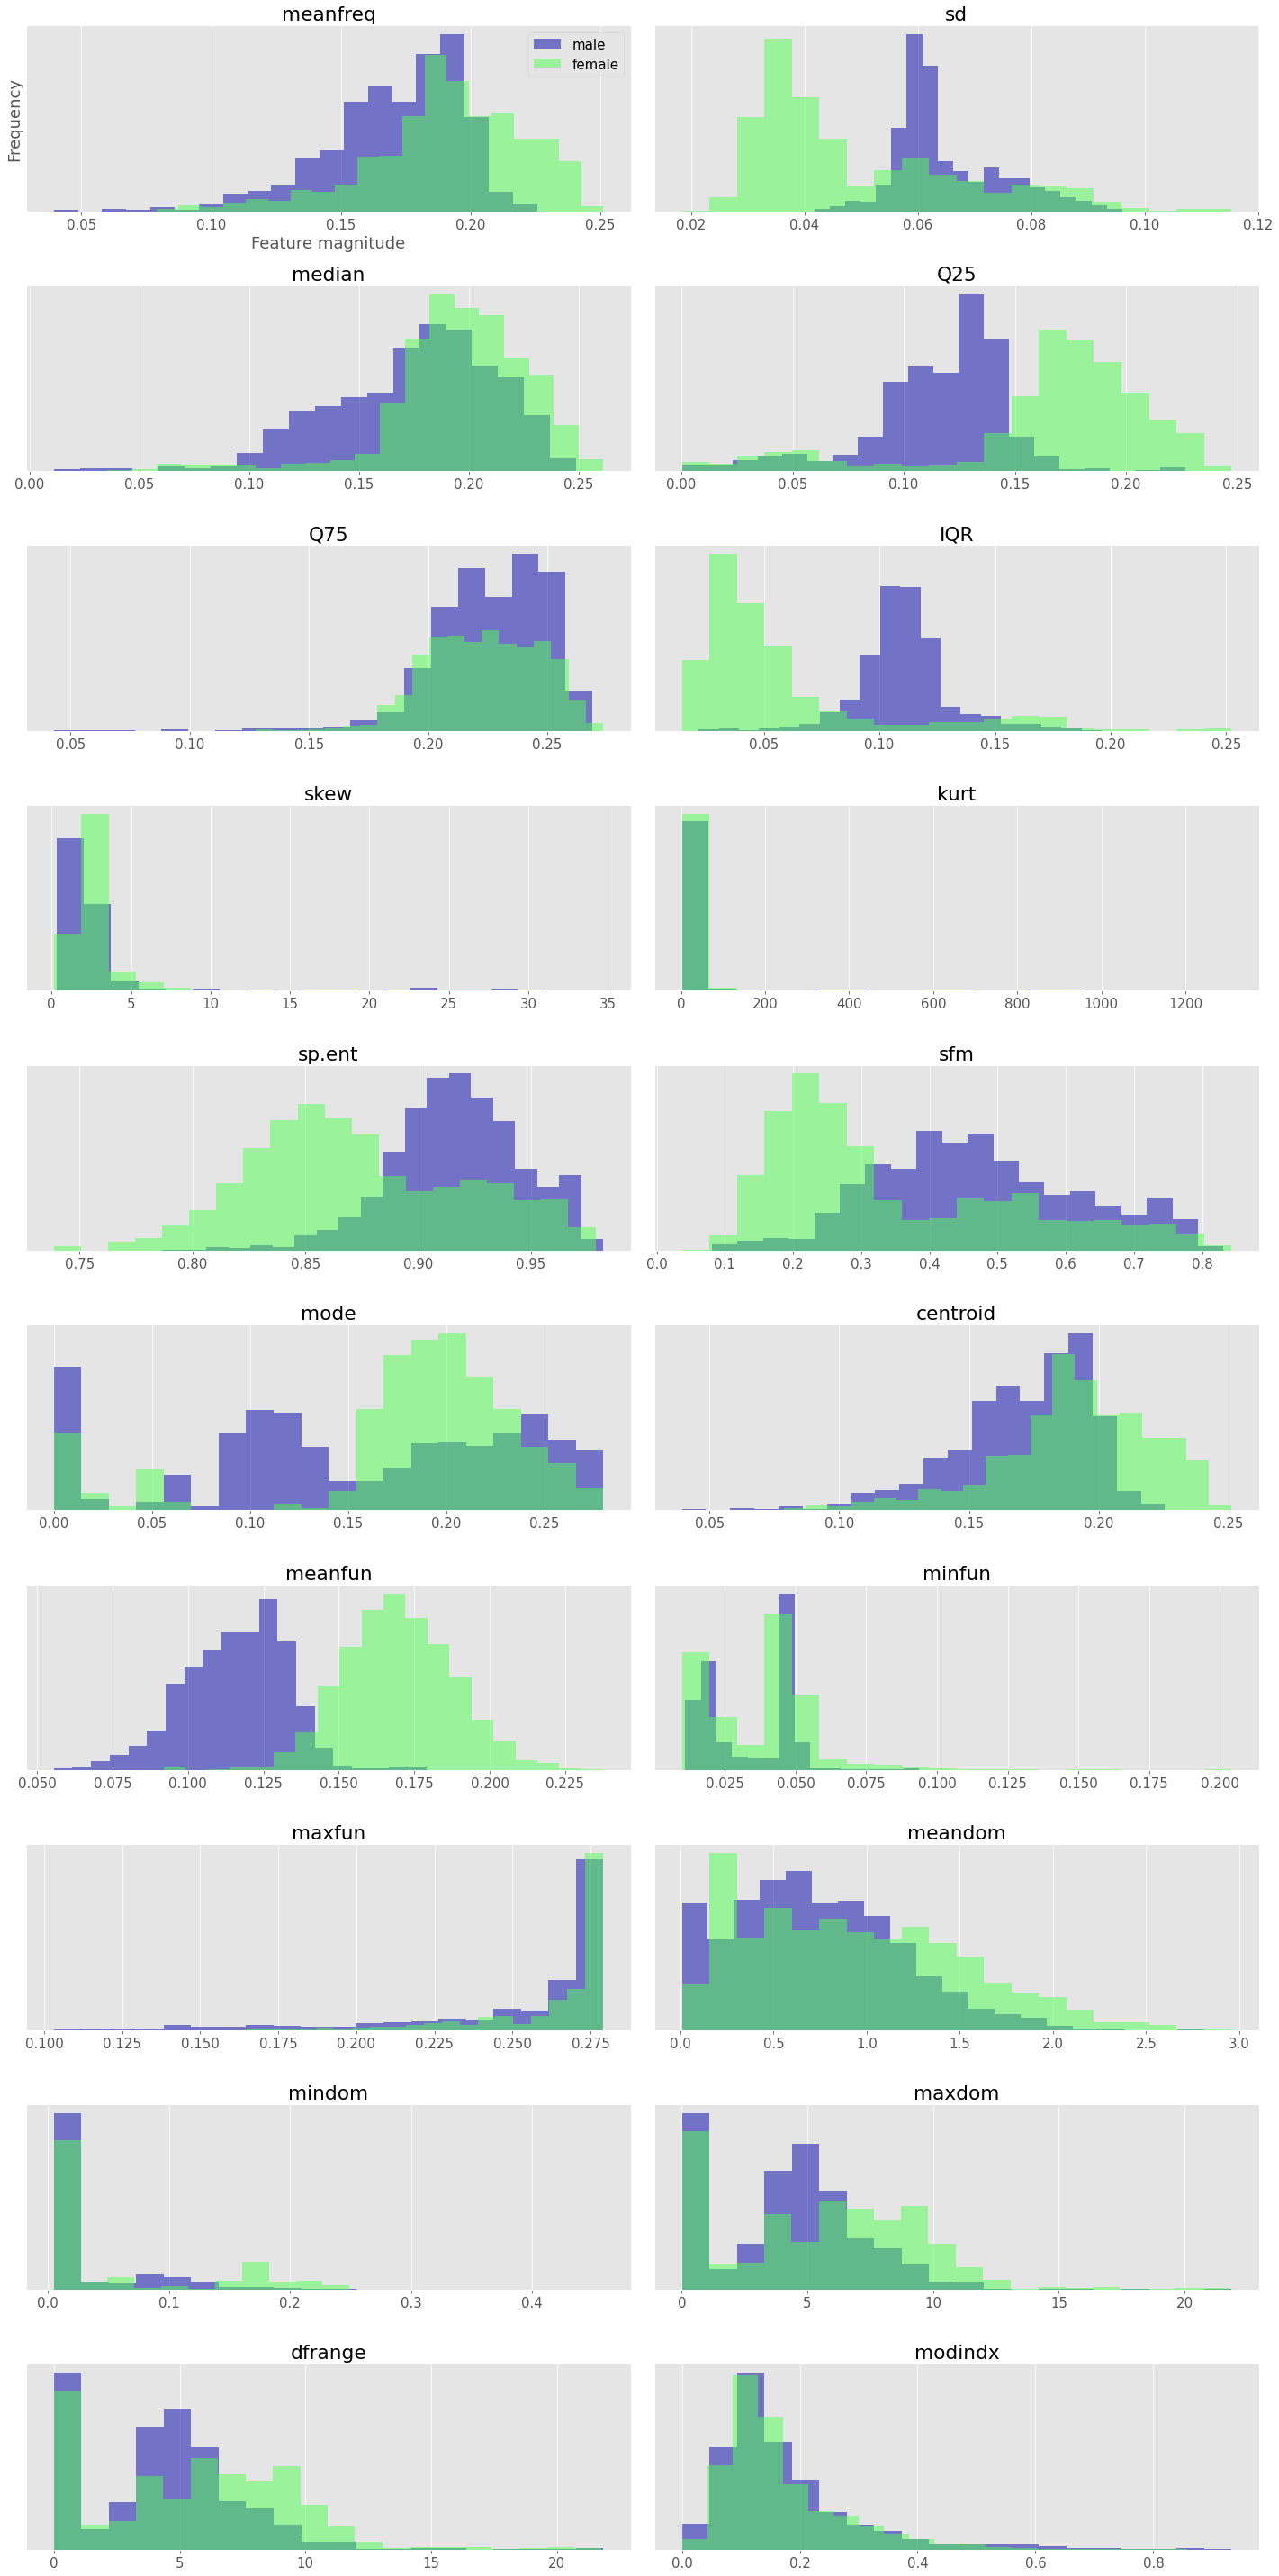

In [48]:
#Plot the histograms
male = mydata.loc[mydata['label']=='male']
female = mydata.loc[mydata['label']=='female']
fig, axes = plt.subplots(10, 2, figsize=(20,40))
ax = axes.ravel()
for i in range(20):
    ax[i].hist(male.iloc[:,i], bins=20, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(female.iloc[:, i], bins=20, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(list(male)[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["male", "female"], loc="best")
fig.tight_layout()

plt.show()

In [49]:
#Prepare data for modeling
mydata.loc[:,'label'][mydata['label']=="male"] = 0
mydata.loc[:,'label'][mydata['label']=="female"] = 1
mydata_train, mydata_test = train_test_split(mydata, random_state=0, test_size=.2)
scaler = StandardScaler()
scaler.fit(mydata_train.iloc[:,0:20])
X_train = scaler.transform(mydata_train.iloc[:,0:20])
X_test = scaler.transform(mydata_test.iloc[:,0:20])
y_train = list(mydata_train['label'].values)
y_test = list(mydata_test['label'].values)

## Decision Tree-based Classification

In [50]:
#Train decision tree model
tree = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0, random_state=100, splitter='best')

tree.fit(X_train, y_train)
print("Decision Tree")
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Decision Tree
Accuracy on training set: 0.951
Accuracy on test set: 0.935


In [52]:
l = list(mydata)
l.remove('label')
print(l)

n_features = X_train.shape[1]
print (n_features)

['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']
20


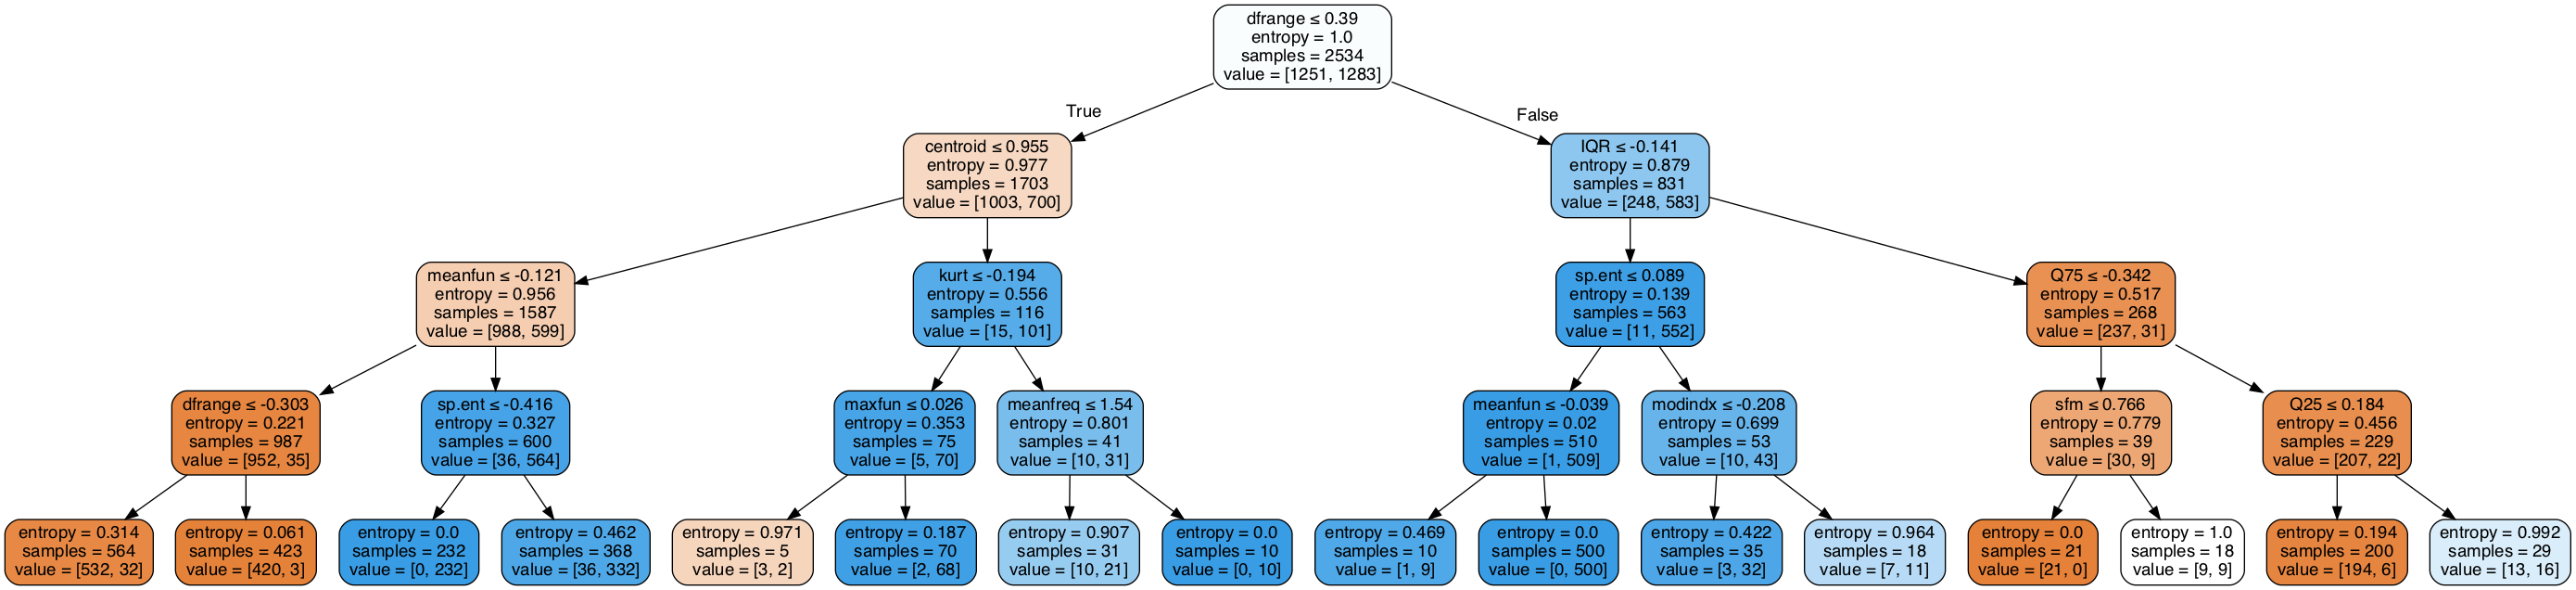

In [53]:
dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=l,  
                         filled=True, rounded=True,  
                         special_characters=True)  
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

#graph = graphviz.Source(dot_data)  
#graph 

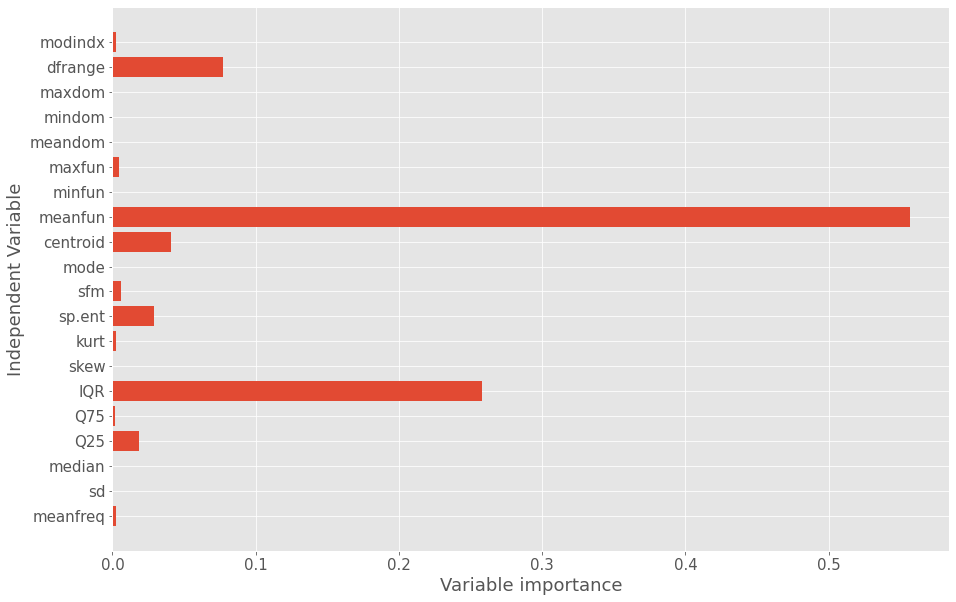

In [54]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,10))

plot_feature_importances_mydata(tree)

plt.show()

In [55]:
#Prepare data for modeling
mydata1 = mydata[['meanfun','IQR','sd','label']]
mydata1.loc[:,'label'][mydata1['label']=="male"] = 0
mydata1.loc[:,'label'][mydata1['label']=="female"] = 1
mydata1_train, mydata1_test = train_test_split(mydata1, random_state=0, test_size=.2)
scaler = StandardScaler()
scaler.fit(mydata1_train.iloc[:,0:3])
X_train = scaler.transform(mydata1_train.iloc[:,0:3])
X_test = scaler.transform(mydata1_test.iloc[:,0:3])
y_train = list(mydata1_train['label'].values)
y_test = list(mydata1_test['label'].values)

tree = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=100, splitter='best')

tree.fit(X_train, y_train)
print("Decision Tree")
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))


Decision Tree
Accuracy on training set: 0.965
Accuracy on test set: 0.950


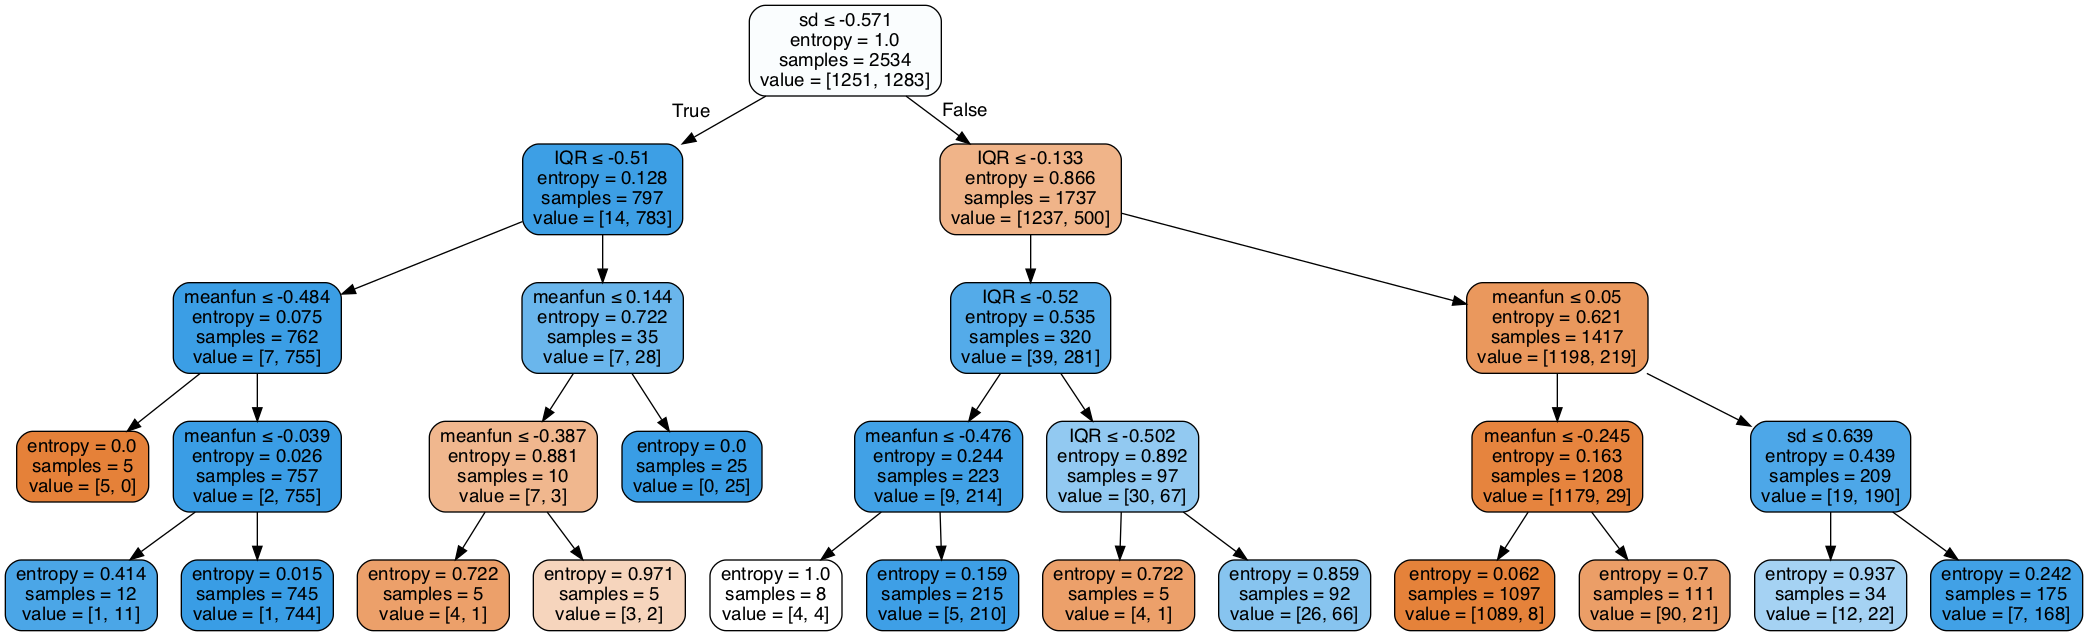

In [56]:
dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=list(mydata1)[:-1],  
                         filled=True, rounded=True,  
                         special_characters=True)  
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())


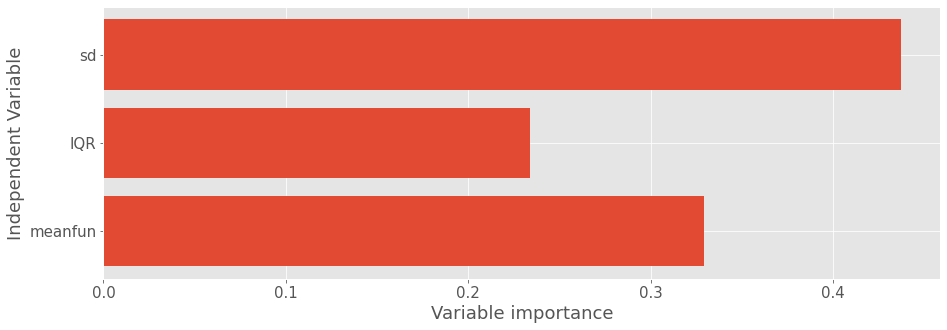

In [57]:
def plot_feature_importances_mydata1(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), list(mydata1)[:-1])
    plt.xlabel("Variable importance")
    plt.ylabel("Independent Variable")
    
plt.figure(figsize=(15,5))
plot_feature_importances_mydata1(tree)

plt.show()

## Random Forest-based Classification

In [17]:
#Read the voice dataset
mydata = pd.read_csv("data/voice.csv")

#Prepare data for modeling
mydata.loc[:,'label'][mydata['label']=="male"] = 0
mydata.loc[:,'label'][mydata['label']=="female"] = 1
mydata_train, mydata_test = train_test_split(mydata, random_state=0, test_size=.2)
scaler = StandardScaler()
scaler.fit(mydata_train.iloc[:,0:20])
X_train = scaler.transform(mydata_train.iloc[:,0:20])
X_test = scaler.transform(mydata_test.iloc[:,0:20])
y_train = list(mydata_train['label'].values)
y_test = list(mydata_test['label'].values)

Random Forests
Accuracy on training set: 0.998
Accuracy on test set: 0.976


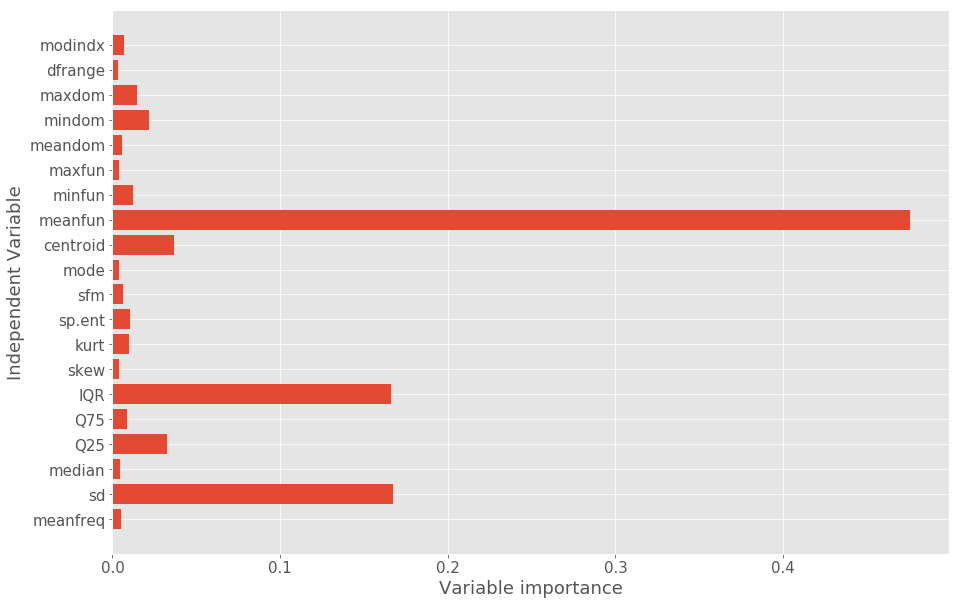

In [18]:
#Train random forest model
forest = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)
print("Random Forests")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,10))
plot_feature_importances_mydata(forest)

plt.show()

Random Forests
Accuracy on training set: 0.996
Accuracy on test set: 0.972


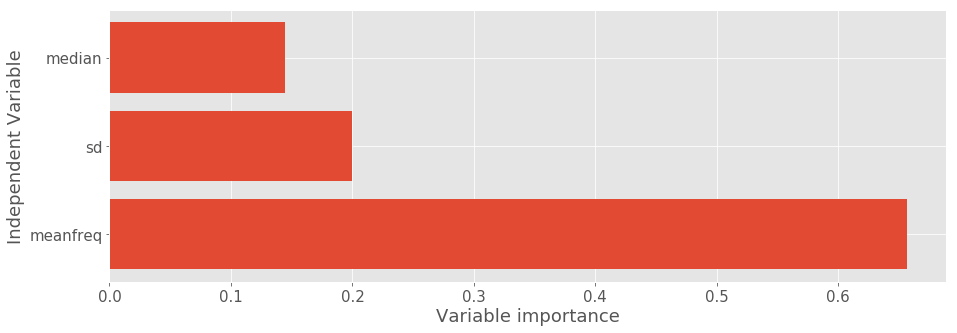

In [19]:
#Prepare data for modeling
mydata1 = mydata[['meanfun','IQR','sd','label']]
mydata1.loc[:,'label'][mydata1['label']=="male"] = 0
mydata1.loc[:,'label'][mydata1['label']=="female"] = 1
mydata1_train, mydata1_test = train_test_split(mydata1, random_state=0, test_size=.2)
scaler = StandardScaler()
scaler.fit(mydata1_train.iloc[:,0:3])
X_train = scaler.transform(mydata1_train.iloc[:,0:3])
X_test = scaler.transform(mydata1_test.iloc[:,0:3])
y_train = list(mydata1_train['label'].values)
y_test = list(mydata1_test['label'].values)

#Train random forest model
forest = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)
print("Random Forests")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

plt.figure(figsize=(15,5))
plot_feature_importances_mydata(forest)

plt.show()